System information (for reproducibility):

In [1]:
versioninfo()

Julia Version 1.8.5
Commit 17cfb8e65ea (2023-01-08 06:45 UTC)
Platform Info:
  OS: macOS (arm64-apple-darwin21.5.0)
  CPU: 12 × Apple M2 Max
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, apple-m1)
  Threads: 1 on 8 virtual cores
Environment:
  JULIA_EDITOR = code


Load packages:

In [2]:
using Pkg
Pkg.activate(pwd())
Pkg.instantiate()
Pkg.status()

  Activating project at `~/Documents/github.com/ucla-biostat-257/2023spring/slides/04-juliaplot`


Status `~/Documents/github.com/ucla-biostat-257/2023spring/slides/04-juliaplot/Project.toml`
  [c91e804a] Gadfly v1.3.4
  [f0f68f2c] PlotlyJS v0.18.10
  [91a5bcdd] Plots v1.38.8
  [d330b81b] PyPlot v2.11.1
  [6f49c342] RCall v0.13.14
  [9a3f8284] Random


In [3]:
using Gadfly, Plots, PlotlyJS, PyPlot, Random, RCall

[ Info: Precompiling Gadfly [c91e804a-d5a3-530f-b6f0-dfbca275c004]


WebIO._IJuliaInit()

# Plotting in Julia

**Warning**: The time to first plot can be frustratingly long in Julia because of the JIT compilation.

The four most popular options (as far as I know) in Julia are

- [Gadfly.jl](https://github.com/GiovineItalia/Gadfly.jl)
    - Julia equivalent of `ggplot2` in R
    
- [PyPlot.jl](https://github.com/JuliaPy/PyPlot.jl)
    - Wrapper for Python's matplotlib
    
    
- [Plots.jl](https://github.com/JuliaPlots/Plots.jl)
    - Defines an unified interface for plotting
    - maps arguments to different plotting "backends"
        - PyPlot, GR, PlotlyJS, and many more  
    - For a complete list of backends: <http://docs.juliaplots.org/latest/backends/>  
    - Mapping of attributes to backends: <http://docs.juliaplots.org/latest/supported/>  
    - First runs can be slowish. I found the GR backend fastest and most stable.
    
- [Makie.jl](https://github.com/JuliaPlots/Makie.jl)  
    - A pure Julia solution. Very extensible. Check [GeneticsMakie.jl](https://github.com/mmkim1210/GeneticsMakie.jl). 

## Gadfly.jl

To demonstrate Gadfly, we will go through an example and compare it to ggplot2. 

┌ Warning: RCall.jl: 
│ Attaching package: ‘dplyr’
│ 
│ The following objects are masked from ‘package:stats’:
│ 
│     filter, lag
│ 
│ The following objects are masked from ‘package:base’:
│ 
│     intersect, setdiff, setequal, union
│ 
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172
┌ Warning: RCall.jl: `summarise()` has grouped output by 'supp'. You can override using the
│ `.groups` argument.
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172


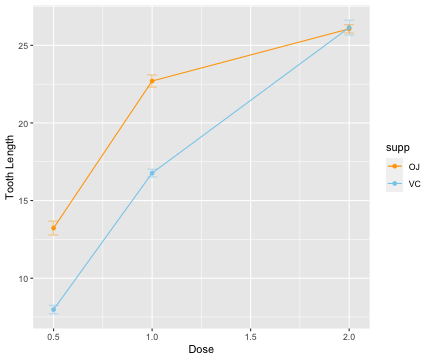

RObject{VecSxp}


In [4]:
using RCall

R"""
library(ggplot2)
library(dplyr)

df <- ToothGrowth %>%
  group_by(supp, dose) %>%
  summarise(se = sd(len) / n(), len = mean(len), n = n())

ggplot(df, aes(x = dose, y = len, group = supp, color = supp)) + 
  geom_line() +
  geom_point() +
  geom_errorbar(aes(ymin = len - se, ymax = len + se), width = 0.1, alpha = 0.5,
  position = position_dodge(0.005)) +  
  scale_color_manual(values = c(VC = "skyblue", OJ = "orange")) + 
  labs(x = "Dose", y = "Tooth Length")
"""

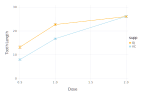

In [5]:
@rget df # retrieve dataframe from R to Julia workspace
using Gadfly
df[!, :ymin] = df[!, :len] - df[!, :se]
df[!, :ymax] = df[!, :len] + df[!, :se]
Gadfly.plot(df, 
    x = :dose, 
    y = :len, 
    color = :supp, 
    Geom.point,
    Guide.xlabel("Dose"), 
    Guide.ylabel("Tooth Length"), 
    Guide.xticks(ticks = [0.5, 1.0, 1.5, 2.0]),
    Geom.line, 
    Geom.errorbar, 
    ymin = :ymin, 
    ymax = :ymax, 
    Scale.color_discrete_manual("orange", "skyblue"))

Both offer more customized options

┌ Warning: RCall.jl: Warning: The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
│ ℹ Please use the `linewidth` argument instead.
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172


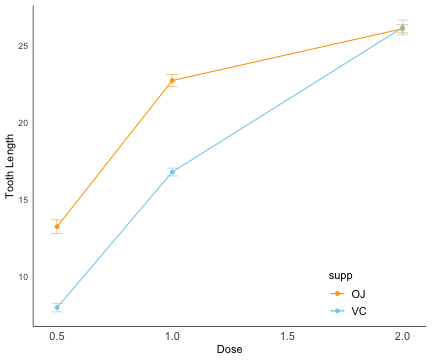

RObject{VecSxp}


In [6]:
R"""
ggplot(df, aes(x = dose, y = len, group = supp, color = supp)) + 
  geom_line() +
  geom_point() +
  geom_errorbar(aes(ymin = len - se, ymax = len + se), width = 0.1, alpha = 0.5, 
    position = position_dodge(0.005)) + 
    theme(legend.position = c(0.8,0.1), 
    legend.key = element_blank(), 
    axis.text.x = element_text(angle = 0, size = 11), 
    axis.ticks = element_blank(), 
    panel.grid.major = element_blank(), 
    legend.text=element_text(size = 11),
    panel.border = element_blank(), 
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), 
    axis.line = element_line(color = 'black',size = 0.3), 
  plot.title = element_text(hjust = 0.5)) + 
  scale_color_manual(values = c(VC = "skyblue", OJ = "orange")) + 
  labs(x = "Dose", y = "Tooth Length")
"""

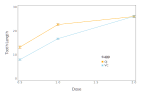

In [7]:
Gadfly.plot(df, x = :dose, y = :len, color = :supp, Geom.point,
    Guide.xlabel("Dose"), Guide.ylabel("Tooth Length"), 
    Guide.xticks(ticks = [0.5, 1.0, 1.5, 2.0]),
    Theme(panel_fill = nothing, highlight_width = 0mm, point_size = 0.5mm,
    key_position = :inside, 
    grid_line_width = 0mm, panel_stroke = colorant"black"),
    Geom.line, Geom.errorbar, ymin = :ymin, ymax = :ymax, 
    Scale.color_discrete_manual("orange", "skyblue"))

## Plots.jl

We demonstrate Plots.jl below:

In [8]:
# Pkg.add("Plots")
using Plots, Random

Random.seed!(123) # set seed
x = cumsum(randn(50, 2), dims=1);

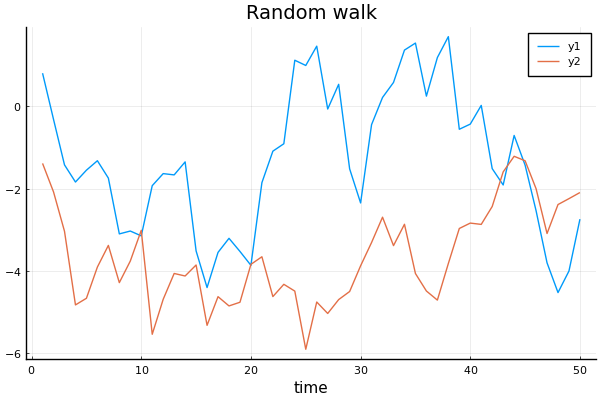

In [9]:
# Pkg.add("PyPlot")
pyplot()  # set the backend to PyPlot
Plots.plot(x, title="Random walk", xlab="time")

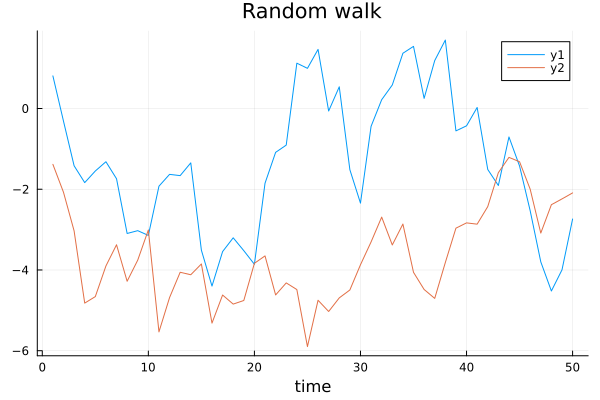

In [10]:
gr()   # change backend to GR
Plots.plot(x, title="Random walk", xlab="time")

```
gr()
@gif for i in 1:20
    Plots.plot(x -> sin(x) / (.2i), 0, i, xlim=(0, 20), ylim=(-.75, .75))
    scatter!(x -> cos(x) * .01 * i, 0, i, m=1)
end;
```
produces following animation.

<img src="./tmp.gif" />

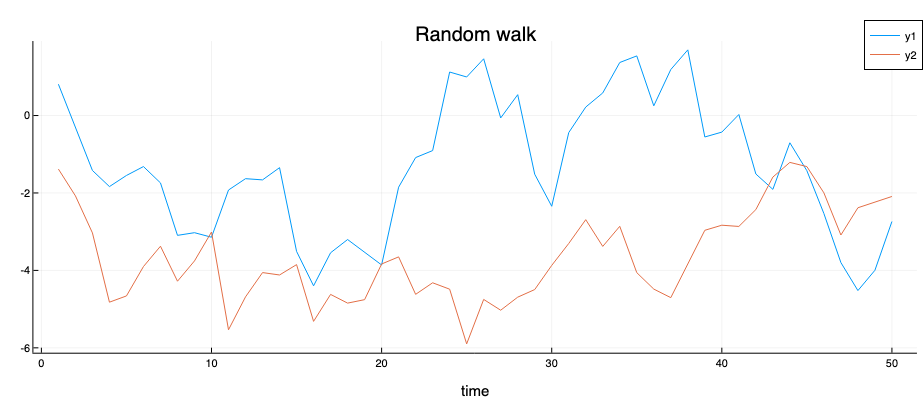

In [11]:
# Pkg.add("PlotlyJS")
plotlyjs()  # change backend to PlotlyJS
Plots.plot(x, title="Random walk", xlab="time")